In [2]:
#Importing necessary modules
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import matplotlib.pyplot as plt

In [3]:
#loading necessary datasets
data1 = pd.read_csv(os.path.join('input', 'music_ratings.csv'))
data2 = pd.read_csv(os.path.join('input', 'music_dataset.csv'))

In [4]:
data1.head()

,user_id,music_id,rating
0,1,4576,2
1,1,6086,3
2,1,5502,2
3,1,5781,2
4,1,7521,2


In [5]:
data2.head()

,music_id,music_name
0,1,Ahe's My Kind Of Girl
1,2,"Andante, Andante"
2,3,As Good As New
3,4,Bang
4,5,Bang-A-Boomerang


# 1. Preprocessing

In [6]:
#merging dataset data1 and data2 on the basis of music_id
data = pd.merge(data1, data2, on='music_id')

In [7]:
#making the columns of merged dataset in order
data = data[['user_id', 'music_id', 'music_name', 'rating']]
data.sort_values(by='user_id', inplace=True)
data.reset_index(drop=True, inplace=True)

In [8]:
data.head()

,user_id,music_id,music_name,rating
0,1,4576,Answer In The Sky,2
1,1,3715,Bella Bella Bambina,5
2,1,5369,Seven Sundays,1
3,1,5204,Wise Guy,2
4,1,4206,Oh Billy Please,5


In [9]:
#saving the merged dataset inside input folder
data.to_csv(os.path.join('input','merged_dataset.csv'), index=False)

In [85]:
#splitting data for training, testing and validation
train_data, remaining_data = train_test_split(data, test_size=0.2)
test_data, val_data = train_test_split(remaining_data, test_size=0.33)

In [67]:
#finding out the unique numbers of users and musics
num_users = data['user_id'].nunique()
num_songs = data['music_id'].nunique()

# 2. Create Model

In [68]:
#hyperparameters for fine tuning of model
EMBEDDING_SIZE = 10
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 0.001

In [69]:
# Create user embedding inpurt and embedding layer
embedding_size = EMBEDDING_SIZE
user_input = Input(shape=(1,))
user_embedding = Embedding(num_users + 1, embedding_size)(user_input)  # Add +1 to handle out-of-bound indices
user_embedding = Flatten()(user_embedding)

# Create song embedding input and embedding layer
song_input = Input(shape=(1,))
song_embedding = Embedding(num_songs + 1, embedding_size)(song_input)  # Add +1 to handle out-of-bound indices
song_embedding = Flatten()(song_embedding)

In [70]:
# Merging both embedding layers to entry as a single input to the neural layers
merged = Concatenate()([user_embedding, song_embedding])

In [71]:
merged

<KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'concatenate_5')>

In [72]:
# Create the connected dense layers with suitable activation functions
dense1 = Dense(64, activation='relu')(merged)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1)(dense2)

In [73]:
# Define the inputs and outputs of the model
model = Model(inputs=[user_input, song_input], outputs=output)

In [74]:
# Set necessary optimizers and loss function to help further during training
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=MeanSquaredError(),  metrics=['mean_squared_error'])

In [75]:
# MOdel Training 
history = model.fit([train_data['user_id'], train_data['music_id']], train_data['rating'], epochs=EPOCHS, batch_size=BATCH_SIZE)


Epoch 1/15
50000/50000 [==============================] - 243s 5ms/step - loss: 2.0218 - mean_squared_error: 2.0218
Epoch 2/15
50000/50000 [==============================] - 246s 5ms/step - loss: 2.0052 - mean_squared_error: 2.0052
Epoch 3/15
50000/50000 [==============================] - 243s 5ms/step - loss: 1.9891 - mean_squared_error: 1.9891
Epoch 4/15
50000/50000 [==============================] - 271s 5ms/step - loss: 1.9480 - mean_squared_error: 1.9480
Epoch 5/15
50000/50000 [==============================] - 254s 5ms/step - loss: 1.8928 - mean_squared_error: 1.8928
Epoch 6/15
50000/50000 [==============================] - 252s 5ms/step - loss: 1.8382 - mean_squared_error: 1.8382
Epoch 7/15
50000/50000 [==============================] - 240s 5ms/step - loss: 1.7884 - mean_squared_error: 1.7884
Epoch 8/15
50000/50000 [==============================] - 249s 5ms/step - loss: 1.7457 - mean_squared_error: 1.7457
Epoch 9/15
50000/50000 [==============================] - 269s 5ms/step 

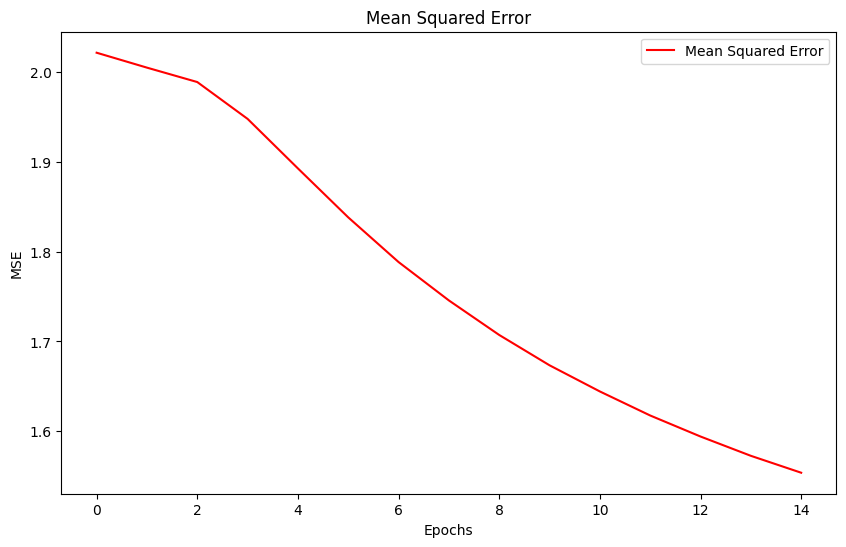

In [76]:
# Get the training history
mse = history.history['mean_squared_error']

# Plot MSE
plt.figure(figsize=(10, 6))
plt.plot(mse, 'r-', label='Mean Squared Error')
plt.title('Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# 3. Make Predictions

In [77]:
# select one random user_id and music_id
user_id = 100
music_id = 5085

In [78]:
# Rating is predicted using trained model
rating = model.predict([np.array([user_id]), np.array([music_id])]).flatten()

1/1 [==============================] - 0s 139ms/step


In [79]:
rating = np.round(rating).astype(int)

In [80]:
print("The predicted rating for music_id: 5000 by the user_id:100 is ", rating[0])

The predicted rating for music_id: 5000 by the user_id:100 is  4


# 4. Evaluate Model

In [84]:
# Predict ratings for the test set
predicted_ratings = model.predict([test_data['user_id'], test_data['music_id']]).flatten()

# Set threshold
threshold = 3

# Classify ratings based on the threshold
predicted_labels = np.where(predicted_ratings>=threshold,1,0).astype(int)
actual_labels = np.where(test_data['rating']>=threshold,1,0).astype(int)

# Calculate precision and recall
precision = precision_score(actual_labels, predicted_labels)
recall = recall_score(actual_labels, predicted_labels)

# Calculate accuracy-like metric
accuracy = np.sum(predicted_labels == actual_labels) / len(actual_labels)

# Print the results
print("The accuracy of the model is : {:.2%}".format(accuracy))
print("Precision:", precision)
print("Recall:", recall)

6250/6250 [==============================] - 11s 2ms/step
The accuracy of the model is : 66.79%
Precision: 0.7559839540675678
Recall: 0.6611575744475666


In [103]:
# Saving the trained model
model.save(os.path.join('model', 'music_recommend.h5'))